读取原始数据：10 条
增强后样本数: 400
序列总数: 380, 每序列长度: 20, 特征维度: 6
训练样本: 304, 测试样本: 76
Epoch 1/1000 | Train Loss: 0.638553 | Best: 0.638553 | Patience: 0/25
Epoch 2/1000 | Train Loss: 0.622878 | Best: 0.622878 | Patience: 0/25
Epoch 3/1000 | Train Loss: 0.607483 | Best: 0.607483 | Patience: 0/25
Epoch 4/1000 | Train Loss: 0.591961 | Best: 0.591961 | Patience: 0/25
Epoch 5/1000 | Train Loss: 0.576639 | Best: 0.576639 | Patience: 0/25
Epoch 6/1000 | Train Loss: 0.561298 | Best: 0.561298 | Patience: 0/25
Epoch 7/1000 | Train Loss: 0.545881 | Best: 0.545881 | Patience: 0/25
Epoch 8/1000 | Train Loss: 0.530284 | Best: 0.530284 | Patience: 0/25
Epoch 9/1000 | Train Loss: 0.514562 | Best: 0.514562 | Patience: 0/25
Epoch 10/1000 | Train Loss: 0.498861 | Best: 0.498861 | Patience: 0/25
Epoch 11/1000 | Train Loss: 0.482731 | Best: 0.482731 | Patience: 0/25
Epoch 12/1000 | Train Loss: 0.466552 | Best: 0.466552 | Patience: 0/25
Epoch 13/1000 | Train Loss: 0.449744 | Best: 0.449744 | Patience: 0/25
Epoch 14/100

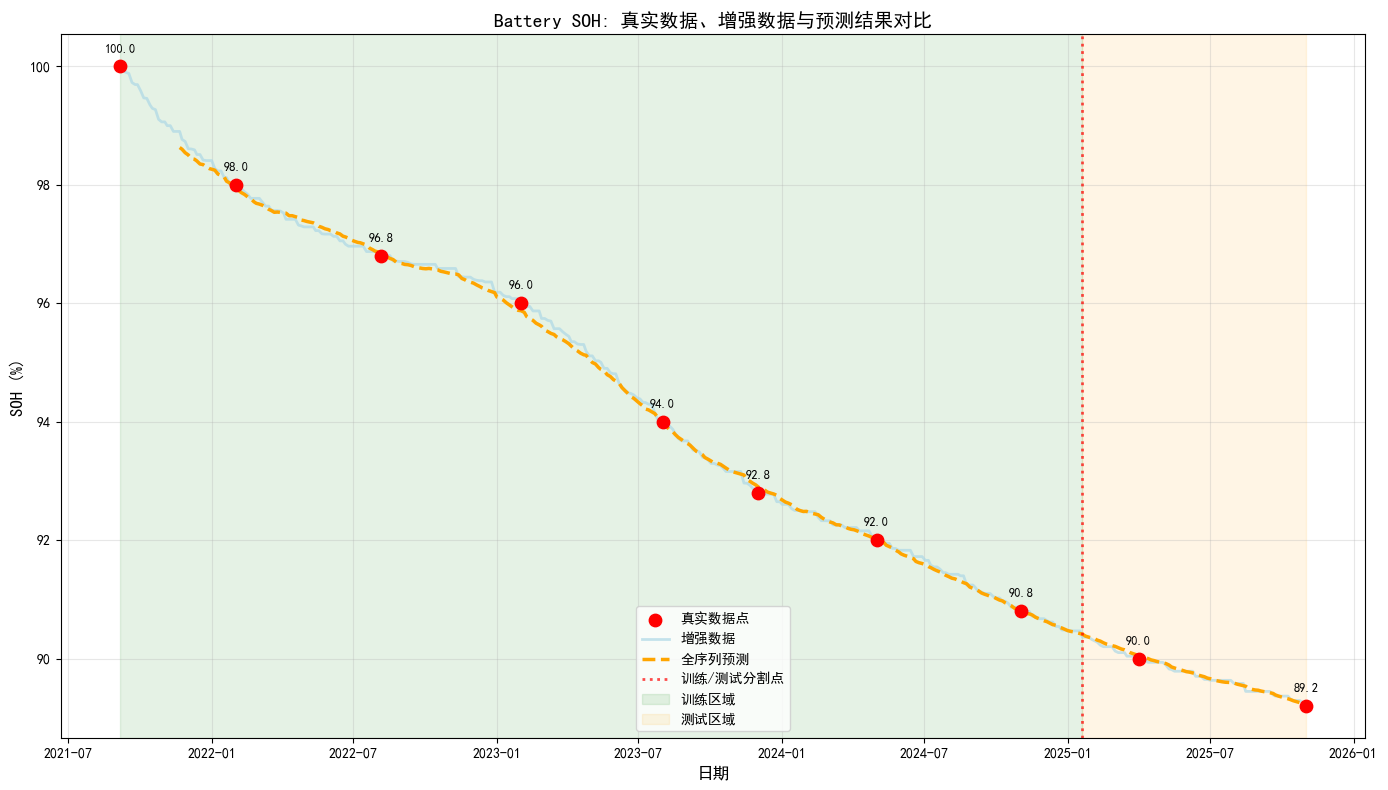


训练与评估完成。评估指标： {'rmse': 0.039059691780227, 'mae': 0.03237107008902216, 'r2': 0.9846101151378873}

真实数据与增强数据对比:
真实数据:
      数据时间   SOH
2021-09-06 100.0
2022-02-01  98.0
2022-08-06  96.8
2023-02-01  96.0
2023-08-01  94.0
2023-12-01  92.8
2024-05-01  92.0
2024-11-02  90.8
2025-04-01  90.0
2025-11-01  89.2

增强数据（部分）:
      数据时间        SOH
2021-09-06 100.000000
2021-09-09  99.926437
2021-09-13  99.899973
2021-09-17  99.878859
2021-09-21  99.726993
2021-09-25  99.692245
2021-09-28  99.692245
2021-10-02  99.590233
2021-10-06  99.467811
2021-10-10  99.458678
...
      数据时间       SOH
2025-09-27 89.367728
2025-10-01 89.367728
2025-10-05 89.367728
2025-10-09 89.367728
2025-10-12 89.322378
2025-10-16 89.292997
2025-10-20 89.292997
2025-10-24 89.292997
2025-10-28 89.261891
2025-11-01 89.261891


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.interpolate import CubicSpline

# ---------------------------
# 固定随机种子，保证可复现
# ---------------------------
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# matplotlib 中文支持（避免字体警告）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 读取 Excel 文件
# ---------------------------
def load_data(file_path):
    df = pd.read_excel(file_path, parse_dates=['数据时间'])
    df = df.sort_values('数据时间').reset_index(drop=True)
    print(f"读取原始数据：{len(df)} 条")
    return df

# ---------------------------
# 基于真实数据的插值增强
# ---------------------------
def augment_data(df, target_points=400, noise_std=0.1):
    # 计算时间索引（天数）
    df = df.copy()
    df['days'] = (df['数据时间'] - df['数据时间'].min()).dt.days
    
    # 使用三次样条插值基于真实数据生成平滑曲线
    cs = CubicSpline(df['days'], df['SOH'])
    
    # 生成更密集的时间点
    dense_days = np.linspace(df['days'].min(), df['days'].max(), target_points)
    
    # 应用插值
    soh_interpolated = cs(dense_days)
    
    # 添加小幅噪声
    noise = np.random.normal(0, noise_std, len(dense_days))
    soh_final = soh_interpolated + noise
    
    # 保证单调递减（电池不会自愈）
    soh_final = np.maximum.accumulate(soh_final[::-1])[::-1]
    
    # 确保不超过100%
    soh_final = np.clip(soh_final, 0, 100)
    
    # 生成日期
    start_date = df['数据时间'].min()
    dense_dates = [start_date + timedelta(days=int(d)) for d in dense_days]
    
    aug_df = pd.DataFrame({'数据时间': dense_dates, 'SOH': soh_final})
    print(f"增强后样本数: {len(aug_df)}")
    
    return aug_df

# ---------------------------
# 特征构造
# ---------------------------
def add_features(df):
    df = df.copy()
    df['time_index'] = (df['数据时间'] - df['数据时间'].min()).dt.days
    df['time_sq'] = df['time_index'] ** 2
    df['delta_soh'] = df['SOH'].diff().fillna(0)
    df['season_sin'] = np.sin(2 * np.pi * df['time_index'] / 180)
    df['season_cos'] = np.cos(2 * np.pi * df['time_index'] / 180)
    return df

# ---------------------------
# 生成滑动窗口序列
# ---------------------------
def create_sequences(data, seq_len=20):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len, 0])  # 目标为 SOH（第0列）
    return np.array(X), np.array(y)

# ---------------------------
# BiLSTM + Attention 模型
# ---------------------------
class AttentionBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=2, dropout=0.1):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=True, dropout=dropout)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        lstm_out, _ = self.bilstm(x)  # [batch, seq_len, hidden*2]
        attn_scores = torch.softmax(self.attn(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_scores * lstm_out, dim=1)  # [batch, hidden*2]
        out = self.fc(context)  # [batch, 1]
        return out.squeeze(-1)  # [batch]

# ---------------------------
# 训练与评估主流程
# ---------------------------
def train_and_evaluate(file_path='soh_data.xlsx', seq_len=20, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1) 读取并增强
    df_raw = load_data(file_path)
    df_aug = augment_data(df_raw, target_points=400, noise_std=0.05)
    df_feat = add_features(df_aug)

    # 2) 归一化：SOH 单独归一化，其他特征单独归一化
    soh_scaler = MinMaxScaler()
    soh_scaled = soh_scaler.fit_transform(df_feat[['SOH']].values)  # shape (N,1)

    other_cols = ['time_index', 'time_sq', 'delta_soh', 'season_sin', 'season_cos']
    feat_scaler = MinMaxScaler()
    feat_scaled = feat_scaler.fit_transform(df_feat[other_cols].values)  # shape (N,5)

    # 合并为模型输入数据（SOH为第0列）
    data = np.hstack([soh_scaled, feat_scaled])  # shape (N, 6)

    # 3) 构建序列
    X, y = create_sequences(data, seq_len=seq_len)
    print(f"序列总数: {len(X)}, 每序列长度: {seq_len}, 特征维度: {X.shape[2]}")

    # 4) 划分训练/测试集（按时间顺序）
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    print(f"训练样本: {len(X_train)}, 测试样本: {len(X_test)}")

    # 转为张量并搬到 device
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

    # 5) 模型、损失、优化器
    input_dim = X.shape[2]
    model = AttentionBiLSTM(input_dim=input_dim, hidden_dim=32).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    # 6) 训练（带 Early Stopping）
    best_loss = float('inf')
    patience = 25
    counter = 0
    max_epochs = 1000

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        pred_train = model(X_train_t)  # [batch]
        loss = criterion(pred_train, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # 早停逻辑
        cur_loss = loss.item()
        if cur_loss < best_loss - 1e-6:
            best_loss = cur_loss
            counter = 0
        else:
            counter += 1

        if (epoch + 1) % 50 == 0 or counter == 0:
            print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {cur_loss:.6f} | Best: {best_loss:.6f} | Patience: {counter}/{patience}")

        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # 7) 在测试集上评估
    model.eval()
    with torch.no_grad():
        pred_test_scaled = model(X_test_t).cpu().numpy()  # scaled SOH
    
    y_test_scaled = y_test

    # 反归一化
    y_test_inv = soh_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()
    pred_test_inv = soh_scaler.inverse_transform(pred_test_scaled.reshape(-1,1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_test_inv, pred_test_inv))
    mae = mean_absolute_error(y_test_inv, pred_test_inv)
    r2 = r2_score(y_test_inv, pred_test_inv)

    print("\n测试集评估：")
    print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

    # 8) 全序列预测（训练集+测试集）
    X_all = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        pred_all_scaled = model(X_all).cpu().numpy()
    
    # 反归一化全序列预测
    pred_all_inv = soh_scaler.inverse_transform(pred_all_scaled.reshape(-1,1)).flatten()
    
    # 对应的真实值（全序列）
    y_all_inv = soh_scaler.inverse_transform(y.reshape(-1,1)).flatten()

    # 9) 绘图：展示真实数据、增强数据和预测结果
    plt.figure(figsize=(14, 8))
    
    # 绘制真实数据点
    plt.scatter(df_raw['数据时间'], df_raw['SOH'], color='red', s=80, zorder=5, label='真实数据点', marker='o')
    
    # 绘制增强数据
    plt.plot(df_feat['数据时间'], df_feat['SOH'], label='增强数据', linewidth=2, color='lightblue', alpha=0.7)
    
    # 绘制全序列预测
    pred_dates = df_feat['数据时间'].iloc[seq_len:].values
    plt.plot(pred_dates, pred_all_inv, '--', label='全序列预测', linewidth=2.5, color='orange')
    
    # 标记训练集和测试集的分割点
    split_date = pred_dates[split_idx]
    plt.axvline(x=split_date, color='red', linestyle=':', alpha=0.7, linewidth=2, label='训练/测试分割点')
    
    # 添加区域标注
    plt.axvspan(df_feat['数据时间'].min(), split_date, alpha=0.1, color='green', label='训练区域')
    plt.axvspan(split_date, df_feat['数据时间'].max(), alpha=0.1, color='orange', label='测试区域')
    
    plt.title('Battery SOH: 真实数据、增强数据与预测结果对比', fontsize=14)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('SOH (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 添加数据点标签
    for i, row in df_raw.iterrows():
        plt.annotate(f"{row['SOH']}", 
                    (row['数据时间'], row['SOH']), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center',
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()

    # 10) 返回评估结果
    return {
        'model': model,
        'soh_scaler': soh_scaler,
        'feat_scaler': feat_scaler,
        'df_raw': df_raw,
        'df_augmented': df_feat,
        'y_true': y_all_inv,
        'y_pred': pred_all_inv,
        'pred_dates': pred_dates,
        'split_date': split_date,
        'metrics': {'rmse': rmse, 'mae': mae, 'r2': r2}
    }

# ---------------------------
# 执行入口
# ---------------------------
if __name__ == '__main__':
    # 修改为你的 Excel 文件路径
    result = train_and_evaluate(file_path='car-dataset/A06655D/soh.xlsx', seq_len=20)
    print("\n训练与评估完成。评估指标：", result['metrics'])
    
    # 打印真实数据与增强数据的对比
    print("\n真实数据与增强数据对比:")
    print("真实数据:")
    print(result['df_raw'][['数据时间', 'SOH']].to_string(index=False))
    print("\n增强数据（部分）:")
    print(result['df_augmented'][['数据时间', 'SOH']].head(10).to_string(index=False))
    print("...")
    print(result['df_augmented'][['数据时间', 'SOH']].tail(10).to_string(index=False))